# PPO and RND for MiniHack: Introduction

In [ ]:
### BEGIN SOLUTION - Student's name
# Dominik Gaweł dg448617
### END SOLUTION

### BEGIN SOLUTION - Message
# ALL_DONE - I have completed every task, and my solutions work correctly
# In this run, TensorBoard is not visible, but as mentioned, it is not a problem.
### END SOLUTION




In this homework, we will explore [<b>Proximal Policy Optimization (PPO)</b>](https://arxiv.org/abs/1707.06347) combined with [<b>Random Network Distillation (RND)</b>](https://arxiv.org/abs/1810.12894) in the context of [MiniHack](https://github.com/facebookresearch/minihack) environments. These environments are challenging procedurally-generated tasks based on the [NetHack Learning Environment (NLE)](https://github.com/heiner/nle), designed to test advanced reinforcement learning algorithms. While PPO is a robust and popular policy optimization algorithm, RND introduces intrinsic rewards to encourage exploration in sparse-reward environments.

The combination of PPO and RND addresses two key challenges in reinforcement learning:
- <b>Sparse Rewards</b>: Many environments provide limited feedback, making it difficult for agents to learn effective policies. RND helps by providing intrinsic rewards based on prediction errors of a randomly initialized network, encouraging exploration.
- <b>Efficient Policy Optimization</b>: PPO uses a clipped surrogate objective to ensure stable and efficient updates to the policy, preventing large deviations that could destabilize training.

Submission requirements:
* Please do not modify anything outside of the `### BEGIN SOLUTION ... ### END SOLUTION` blocks (if you feel it might be useful somewhere, ask on slack).
* Don't use `tqdm.notebook` or `tqdm.auto`, just plain `tqdm`.
* Don't use additional libraries than provided - see/run `hw4-rl_hw_tester_student` for reference.
* Use only provided context objects and variables for each solution (common: numpy, torch) - example: (numpy, torch, self, x, action) - see/run `hw4-rl_hw_tester_student` for reference.
* Include your full name in the designated solution field **Student\'s name** - **required**.
* Use the designated solution field **Message** for additional information to assist the reviewing instructor - optional.
* It should be possible to execute the notebook from top to bottom when loaded in Colab with a GPU in a reasonable amount of time (perfect solution about 2h).
* Plots should either be images embedded in cell outputs (in a way that shows correctly when loading the notebook from the file, without executing it), or attached with the exported .ipynb notebook in a .zip file (screenshots are admissible, but prefer exporting with e.g. `plt.savefig()`). At the end of the notebook method `save_static_plots_in_notebook` will embed sufficient plots automatically.
* Please submit your solution as a notebook with saved cell outputs.
* There is one provided completed solution for reference which has its own test - `PPOT compute_advantages`.
* **(IMPORTANT) Make sure that every correctly completed solution passes its designated test in `hw4-rl_hw_tester_student` notebook.**


## Installation
You will have to restart session on Google Colab

(when configuring local env refer to local_config_instructions document)

In [1]:
# works for Google Colab
!pip install tyro
!pip install imageio[ffmpeg]
!pip install pufferlib==1.0
!pip install --upgrade tensorboard
!pip install "https://github.com/BartekCupial/nle/releases/download/fair/nle-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl"
!pip install minihack

  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 1.23.3 which is incompatible.
tensorflow 2.17.1 requires tensorboard<2.18,>=2.17, but you have tensorboard 2.18.0 which is incompatible.
  Using cached https://github.com/BartekCupial/nle/releases/download/fair/nle-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.4/248.4 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for minihack: filename=minihack-0.1.6-py3-none-any.whl size=288602 sha256=10894b1

### Alternative local installation tips
(Ubuntu Linux)

sudo apt update && sudo apt upgrade -y

sudo apt install python3 python3-pip python3-venv build-essential cmake git -y \
sudo apt install libffi-dev libbz2-dev liblzma-dev zlib1g-dev libncurses5-dev libncursesw5-dev -y \
sudo apt install flex bison

conda create -n rl_hw python=3.10 \
conda activate rl_hw

(in env)

pip install tyro \
pip install imageio[ffmpeg] \
pip install pufferlib==1.0 \
pip install --upgrade tensorboard \
pip install minihack

other libs can be installed via “conda install”


## Imports

In [2]:
import random
import argparse
import time
from functools import partial
from collections import deque
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gym.wrappers.normalize import RunningMeanStd
from torch.utils.tensorboard import SummaryWriter

# RL library for vectorized environments
import pufferlib
import pufferlib.vector
import pufferlib.emulation

## Loggers

In [3]:
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
from google.colab import output # only for Google Colab
output.enable_custom_widget_manager()

class TrainingLolcaLogger:
    def __init__(self):
        self.loss = self.init_line_plot(title='Training entropy loss', xaxis_title='Global step')
        self.ave_er = self.init_line_plot(title='Training average episode return', xaxis_title='Global step')
        self.ave_cr = self.init_line_plot(title='Training average curiosity reward', xaxis_title='Global step')
        self.sps = self.init_line_plot(title='Steps Per Socond', xaxis_title='Global step')

        self.loss.data[0].name = f'PPO'
        self.loss.data[1].name = f'PPO+RND'
        self.ave_er.data[0].name = f'PPO'
        self.ave_er.data[1].name = f'PPO+RND'
        self.ave_cr.data[0].name = f'PPO+RND'
        self.sps.data[0].name = f'PPO'
        self.sps.data[1].name = f'PPO+RND'


    def init_line_plot(
        self,
        title,
        x=None, xaxis_title=None,
        yaxis_title=None, yaxis_type='linear',
        mode='lines'
    ):
        fig = go.Figure()
        fig.update_layout(
            title=title, title_x=0.5,
            xaxis_title=xaxis_title, yaxis_title=yaxis_title,
            height=400, width=1500, margin=dict(b=10, t=60)
        )
        fig.update_yaxes(type=yaxis_type)
        for _ in range(25):
            fig.add_trace(go.Scatter(x=[], y=[], showlegend=True, mode=mode))

        fig_widget = go.FigureWidget(fig)
        display(fig_widget)
        return fig_widget

    def plot_ppo_loss(self, loss, step):
        self.loss.data[0].y += (loss, )
        self.loss.data[0].x += (step, )

    def plot_rnd_loss(self, loss, step):
        self.loss.data[1].y += (loss, )
        self.loss.data[1].x += (step, )

    def plot_ppo_er(self, er, step):
        self.ave_er.data[0].y += (er, )
        self.ave_er.data[0].x += (step, )

    def plot_rnd_er(self, er, cr, step):
        self.ave_er.data[1].y += (er, )
        self.ave_er.data[1].x += (step, )
        self.ave_cr.data[0].y += (cr, )
        self.ave_cr.data[0].x += (step, )

    def plot_ppo_sps(self, sps, step):
        self.sps.data[0].y += (sps, )
        self.sps.data[0].x += (step, )

    def plot_rnd_sps(self, sps, step):
        self.sps.data[1].y += (sps, )
        self.sps.data[1].x += (step, )

    def save_static_plots_in_notebook(self):
        # Convert each FigureWidget to a regular Figure and display it using matplotlib
        static_loss = go.Figure(self.loss)
        static_ave_er = go.Figure(self.ave_er)
        static_ave_cr = go.Figure(self.ave_cr)
        static_sps = go.Figure(self.sps)

        # Plot loss
        plt.figure()
        for trace in static_loss.data:
            plt.plot(trace.x, trace.y, label=trace.name)
        plt.title("Training entropy loss")
        plt.xlabel("Global step")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        # Plot average episode return
        plt.figure()
        for trace in static_ave_er.data:
            plt.plot(trace.x, trace.y, label=trace.name)
        plt.title("Training average episode return")
        plt.xlabel("Global step")
        plt.ylabel("Episode Return")
        plt.legend()
        plt.show()

        # Plot curiosity reward
        plt.figure()
        for trace in static_ave_cr.data:
            plt.plot(trace.x, trace.y, label=trace.name)
        plt.title("Training average curiosity reward")
        plt.xlabel("Global step")
        plt.ylabel("Curiosity Reward")
        plt.legend()
        plt.show()

        # Plot SPS
        plt.figure()
        for trace in static_sps.data:
            plt.plot(trace.x, trace.y, label=trace.name)
        plt.title("Steps per socond")
        plt.xlabel("Global step")
        plt.ylabel("SPS")
        plt.legend()
        plt.show()


tlol = TrainingLolcaLogger()

FigureWidget({
    'data': [{'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'd90d4034-7c61-4fcd-bab4-8f138f253ac6',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '98aa16ce-e0ad-40c2-ab76-ceae94f9e9ed',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '0db12f88-205a-46f4-9700-04fbcfd6d7d5',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '13300774-bc78-4890-8c8d-339108ac58b0',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '21925499-871c-4a65-a1aa-6b4b00c3e39e',
  

FigureWidget({
    'data': [{'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'daa8889a-8a44-418a-8d0d-c4ae32a3b13d',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '60c39bdc-2b72-441d-979f-2922897c26fd',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '13a70b6d-5fa5-40b1-8306-52d721424c32',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '501e0ec2-b98c-4068-9c1c-b93f8dc17509',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'fce8cb79-0055-4a2e-9710-ad0decd3741b',
  

FigureWidget({
    'data': [{'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '0e95593d-4855-41a7-9af4-554f2fe3526b',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '7c07311d-1927-41a4-97a6-f7b423fc9015',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'a25dd9d8-e29f-4a7d-922e-3295349292fd',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'ac1f50e7-ace6-425b-b028-e01c83298807',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'cd29d7d1-19fb-43d9-bc6b-364185e1209a',
  

FigureWidget({
    'data': [{'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'c20da99e-4e5b-4bcf-8503-e2c94dc5d99b',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'bdd6f4e0-6ce3-4ad0-967b-d9345aeb0d6f',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'ba4721d1-0c09-4735-8c34-ffd43d83ae94',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'bc159531-98c5-4303-962c-ef50f941c882',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '4d38bd8e-f558-4313-b6c3-8bce006eacf9',
  

In [32]:
%load_ext tensorboard
%tensorboard --logdir runs --verbosity=1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2025-01-29 00:39:37.457932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-29 00:39:37.478208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 00:39:37.484192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 00:39:38.594290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1738111180.054282   35982 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so 

## Argument Parsing

In [5]:
def str2bool(v):
    if isinstance(v, bool):
        return v
    if isinstance(v, str) and v.lower() in ("true",):
        return True
    elif isinstance(v, str) and v.lower() in ("false",):
        return False
    else:
        raise argparse.ArgumentTypeError("Boolean value expected")


@dataclass
class Args:
    exp_name: str = "ppo_rnd"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: str2bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: str2bool = True
    """if toggled, cuda will be enabled by default"""
    track: str2bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: str2bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    # Algorithm specific arguments
    env_id: str = "MiniHack-KeyRoom-Dark-S5-v0"
    """the id of the environment"""
    max_episode_steps: int = None
    """number of episode steps"""
    total_timesteps: int = 5000000
    """total timesteps of the experiments"""
    learning_rate: float = 2e-4
    """the learning rate of the optimizer"""
    num_envs: int = 128
    """the number of parallel game environments"""
    num_workers: int = 16
    """the number of workers"""
    num_steps: int = 128
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: str2bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.999
    """the discount factor gamma"""
    gae_lambda: float = 0.95
    """the lambda for the general advantage estimation"""
    num_minibatches: int = 8
    """the number of mini-batches"""
    update_epochs: int = 8
    """the K epochs to update the policy"""
    norm_adv: str2bool = True
    """Toggles advantages normalization"""
    clip_coef: float = 0.1
    """the surrogate clipping coefficient"""
    clip_vloss: str2bool = True
    """Toggles whether or not to use a clipped loss for the value function, as per the paper."""
    ent_coef: float = 0.001
    """coefficient of the entropy"""
    vf_coef: float = 0.5
    """coefficient of the value function"""
    max_grad_norm: float = 40
    """the maximum norm for the gradient clipping"""
    target_kl: float = None
    """the target KL divergence threshold"""
    penalty_step: float = 0.0
    """the penalty for each env step"""
    value_bootstrap: str2bool = True
    """Value bootstrapping"""

    # RND arguments
    update_proportion: float = 1.0
    """proportion of exp used for predictor update"""
    int_coef: float = 0.1
    """coefficient of extrinsic reward"""
    ext_coef: float = 1.0
    """coefficient of intrinsic reward"""
    int_gamma: float = 0.99
    """Intrinsic reward discount rate"""
    num_iterations_obs_norm_init: int = 5
    """number of iterations to initialize the observations normalization parameters"""
    forward_coef: float = 0.1
    """weight on modelling loss (ie convergence of predictor)"""

    # to be filled in runtime
    batch_size: int = 0
    """the batch size (computed in runtime)"""
    minibatch_size: int = 0
    """the mini-batch size (computed in runtime)"""
    num_iterations: int = 0
    """the number of iterations (computed in runtime)"""

## RecordEpisodeStatistics, RewardForwardFilter, layer_init

In [6]:
class RecordEpisodeStatistics:
    def __init__(self, env, deque_size=100):
        self.env = env
        self.num_envs = getattr(env, "num_envs", 1)
        self.episode_returns = None
        self.episode_lengths = None

    def __getattr__(self, name):
        return getattr(self.env, name)

    def reset(self, **kwargs):
        observations, infos = self.env.reset(**kwargs)
        self.episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        self.lives = np.zeros(self.num_envs, dtype=np.int32)
        self.returned_episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.returned_episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        return observations, {}

    def step(self, action):
        observations, rewards, terminatedes, truncatedes, infos = self.env.step(action)
        self.episode_returns += rewards
        self.episode_lengths += 1
        self.returned_episode_returns[:] = self.episode_returns
        self.returned_episode_lengths[:] = self.episode_lengths
        self.episode_returns *= 1 - terminatedes
        self.episode_lengths *= 1 - terminatedes

        infos = {}
        infos["r"] = self.returned_episode_returns
        infos["l"] = self.returned_episode_lengths

        return (
            observations,
            rewards,
            terminatedes,
            truncatedes,
            infos,
        )


class RewardForwardFilter:
    def __init__(self, gamma):
        self.rewems = None
        self.gamma = gamma

    def update(self, rews):
        if self.rewems is None:
            self.rewems = rews
        else:
            self.rewems = self.rewems * self.gamma + rews
        return self.rewems


# ALGO LOGIC: initialize agent here:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

## Create Envs

In [7]:
import gymnasium
from nle.env.base import NLE

class NLETimeLimit(gymnasium.Wrapper):
    def __init__(self, env: gymnasium.Env):
        super().__init__(env)

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        if "end_status" in info:  # Add safety check
            if info["end_status"] == NLE.StepStatus.ABORTED:
                truncated = True
        return obs, reward, terminated, truncated, info


def env_creator(args):
    '''NetHack binding creation function'''
    import minihack
    import gym
    import shimmy
    from pufferlib.environments.minihack.environment import MinihackWrapper, EXTRA_OBS_KEYS

    obs_key = minihack.base.MH_DEFAULT_OBS_KEYS + EXTRA_OBS_KEYS
    kwargs = dict(
        observation_keys=obs_key,
        penalty_step=args.penalty_step,
    )
    env = gym.make(args.env_id, **kwargs)
    env = shimmy.GymV21CompatibilityV0(env=env)
    env = NLETimeLimit(env)
    env = MinihackWrapper(env)
    return pufferlib.emulation.GymnasiumPufferEnv(env=env)

def create_env(args):
    env = pufferlib.vector.make(partial(env_creator, args), batch_size=args.num_envs, num_envs=args.num_envs, num_workers=args.num_workers, backend=pufferlib.vector.Multiprocessing)
    env = RecordEpisodeStatistics(env)
    return env

## VideoRecorder

In [8]:
import imageio
import pathlib
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Video


class VideoRecorder:
    def __init__(self, env, directory, size=(512, 512)):
        self.env = env
        self._directory = pathlib.Path(directory).expanduser()
        self._directory.mkdir(exist_ok=True, parents=True)
        self._size = size
        self._frames = None

    def __getattr__(self, name):
        return getattr(self.env, name)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self._frames = [self.render_image()]
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self._frames.append(self.render_image())

        if terminated or truncated:
            self._save()

        return obs, reward, terminated, truncated, info

    def _save(self):
        if self._frames:
            filename = str(self._directory / "trajectory.mp4")
            imageio.mimsave(filename, self._frames)

    def render_image(self):
        obs = self.env.env.env.gym_env.last_observation
        obs_keys = self.env.env.env.gym_env._observation_keys
        tty_chars = obs[obs_keys.index("tty_chars")]
        tty_colors = obs[obs_keys.index("tty_colors")]
        tty_cursor = obs[obs_keys.index("tty_cursor")]
        image = tty_render(tty_chars, tty_colors, tty_cursor, font_path=None)
        image = image.resize((600, 430))
        return np.asanyarray(image)


def tty_render(chars, colors, cursor=None, font_size=16, font_path="Hack-Regular.ttf"):
    # Create font object
    font = ImageFont.truetype(font_path, font_size) if font_path else ImageFont.load_default()

    height, width = chars.shape
    line_height = font_size + 6
    line_width = font_size - 6

    # Create image
    img = Image.new("RGB", (width * line_width, height * line_height), color="black")
    draw = ImageDraw.Draw(img)

    color_palette = [
        (0, 0, 0),
        (255, 0, 0),
        (0, 255, 0),
        (255, 255, 0),
        (0, 0, 255),
        (255, 0, 255),
        (0, 255, 255),
        (255, 255, 255),
    ]

    color_palette = [
        # Standard colors (30-37)
        (0, 0, 0),  # Black
        (255, 0, 0),  # Red
        (0, 255, 0),  # Green
        (255, 255, 0),  # Yellow
        (0, 0, 255),  # Blue
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Cyan
        (255, 255, 255),  # White
        # Bright colors (90-97)
        (128, 128, 128),  # Bright Black / Gray
        (255, 85, 85),  # Bright Red
        (85, 255, 85),  # Bright Green
        (255, 255, 85),  # Bright Yellow
        (85, 85, 255),  # Bright Blue
        (255, 85, 255),  # Bright Magenta
        (85, 255, 255),  # Bright Cyan
        (255, 255, 255),  # Bright White
    ]

    if cursor is None:
        cursor = (-1, -1)
    cursor = tuple(cursor)

    rows, cols = chars.shape
    y = 0
    for i in range(rows):
        x = 0
        for j in range(cols):
            draw.text((x, y), chr(chars[i, j]), fill=color_palette[colors[i, j] % 16], font=font)
            if cursor == (i, j):
                draw.text((x, y + 2), "_", fill=color_palette[7], font=font)

            x += line_width
        y += line_height

    return img


@torch.no_grad
def play(agent, args):
    env = env_creator(args)
    env = VideoRecorder(env, ".")
    obs, info = env.reset()

    device = next(agent.parameters()).device

    steps = 0
    reward = 0.0
    total_reward = 0.0

    while True:
        action = agent.get_action_and_value(torch.Tensor(obs).unsqueeze(0).to(device))[0][0].item()
        obs, reward, terminated, truncated, info = env.step(action)

        steps += 1
        total_reward += reward

        if not (terminated or truncated):
            continue

        break
    print(f"reward: {reward}, steps: {steps}")
    env.close()
    return info

# Task 1: PPO

## Motivation
Policy optimization methods in reinforcement learning face two major challenges: <b>sample inefficiency</b> and <b>training instability</b>. On-policy methods require fresh data collection for each policy update, making them sample inefficient since data cannot be reused once the policy changes. Additionally, early policy gradient approaches often suffered from instability during training, as large parameter updates could lead to performance collapse.

<b>Trust Region Policy Optimization (TRPO)</b> attempted to address these issues by introducing constraints on policy updates. However, TRPO's reliance on complex second-order optimization made it computationally expensive and difficult to implement. This led to the development of <b>Proximal Policy Optimization (PPO)</b>, which maintains TRPO's benefits while simplifying the implementation.

## Core Idea

The fundamental idea behind PPO is to prevent excessive policy changes during training by implementing a "clip" mechanism. This clipping function ensures that the ratio between new and old policies stays within a small range, typically $[1-\epsilon,1+\epsilon]$ where $\epsilon$ is usually between 0.1 and 0.2. When the policy update results in a ratio outside this range, the clipping function restricts the change, effectively creating a trust region without the computational complexity of second-order methods


PPO operates in two main phases: data collection and optimization. During data collection, the algorithm gathers trajectories using the current policy. In the optimization phase, it performs multiple epochs of minibatch updates on this collected data. $\pi_{\theta_{old}(a_t|s_t)}$ are outputs of the actor when we collected the data, $\pi_{\theta_{old}(a_t|s_t)}$ are the outputs of the policy after we performed minibatch update.

The PPO objective function is defined as:

$$ L^{CLIP}(\theta)=\hat {\mathbb{E}}_t \left [ \min(r_t(\theta) \hat A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat A_t) \right ] $$

Here, $t$ indexes the time steps in the collected trajectories, $A_t$ denotes the estimated advantage function, and the probability ratio is defined as:

$$r_t(\theta) = {\pi_\theta(a_t|s_t) \over \pi_{\theta_{old}}(a_t|s_t)}$$

The hat over $A_t$ signifies that it is an **estimator** of the advantage function, and the hat over $E_t$ indicates an **empirical average** used to approximate the true expectation.

The objective function maximizes the expected return by increasing the likelihood of actions with positive advantages ($A_t > 0$) while decreasing the likelihood of actions with negative advantages ($A_t < 0$). This balanced approach facilitates stable policy improvement. The expectation operator $\mathbb{E}_t$ indicates averaging over the sampled trajectories during data collection.

## Implementation Details

1. <b>Actor</b>: The actor represents the policy, $\pi_\theta(a_t|s_t)$, which maps states to a probability distribution over actions. It is responsible for deciding what action the agent should take in a given state. During training, the actor is updated to maximize the PPO objective function by either increasing or decreasing the likelihood of actions based on their estimated advantages.

2. <b>Critic</b>: The critic estimates the value of a state, typically using a value function $V_{\phi}(s_t)$. This value function helps determine how "good" a particular state is by predicting the expected cumulative reward from that state onward. The critic is trained to minimize the mean squared error between its predictions and the actual discounted returns observed during training.

3. <b>Data Collection</b>: In this phase, trajectories are collected by having the agent interact with the environment using its current policy $\pi_{\theta_{old}}(a_t|s_t)$. Each trajectory contains sequences of states, actions, rewards, and log probabilities of actions under the current policy. These trajectories are used to compute several key quantities:
  - Discounted Returns: The cumulative rewards from each state onward.

 $$ G_t = \sum_{t=0}^{∞} \gamma^t r_t $$
 $$ G_t = \sum_{t=0}^k \gamma^t r_t + V_{\phi}(s_{k+1})  $$

  - Advantages: The difference between observed returns and predicted state values. PPO uses Generalized Advantage Estimation (GAE) to compute these advantages efficiently and reduce variance.
  
 $$ \hat{A}_t^{GAE(\gamma, \lambda)} = \sum_{l=0}^∞ (\gamma \lambda)^l \delta_{t+l}^V$$
 $$\delta_t^V=-V(s_t) + r_t + \gamma V(s_{t+1})$$

4. <b>Optimization</b>: Once data is collected, PPO performs multiple epochs of minibatch updates on this data to improve both the actor (policy network) and the critic (value network). The optimization process involves:
  - Policy Update (Actor): The PPO objective function is used to update the policy network.
  
 $$ L^{CLIP}(\theta)=\hat {\mathbb{E}}_t \left [ \min(r_t(\theta) \hat A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat A_t) \right ] $$

  - Value Function Update (Critic): The critic network is updated by minimizing a mean squared error loss. Here, $G_t$ represents the discounted return or target value for state $s_t$
  
 $$L^{VF}=\frac{1}{2N}\sum_{t=1}^{N}(V_{\phi}(s_t)-G_t)^2$$
  
  - Entropy Regularization: To encourage exploration and prevent premature convergence to suboptimal policies, an entropy term is often added to the loss function.

 $$L^{ENTROPY}=-\beta \sum_{\alpha} \pi_{\theta}(a|s) \text{log} \pi_{\theta}(a|s)$$

## Training Loop
The overall training loop for PPO can be summarized as follows:
- Collect trajectories using the current policy.
- Compute discounted returns and advantages using GAE.
- Perform multiple epochs of minibatch updates on both:
  - The actor using the clipped surrogate objective.
  - The critic using mean squared error loss.
- Repeat until convergence or until a predefined number of iterations is reached.

## References

- PPO: [J. Schulman et al., "Proximal Policy Optimization Algorithms." arXiv preprint arXiv:1707.06347, 2017.](https://arxiv.org/abs/1707.06347.pdf)
- TRPO: [Schulman, John, et al. "Trust region policy optimization." International conference on machine learning. 2015.](http://proceedings.mlr.press/v37/schulman15.pdf)
- GAE: [Schulman, John, et al. "High-dimensional continuous control using generalized advantage estimation."](https://arxiv.org/abs/1506.02438)

## Implement Agent class

We will use a shared encoder and three linear networks for the actor and two critics respectively. The encoder network consists of three parts:
1. A `blstats_net` that processes game statistics through an embedding layer,
2. A convolutional network (`chars_net`) that processes the game's character-based display after embedding each character,
3. A combination layer that merges and projects down these features.

Projected features are then fed into three output heads:
- actor that decides actions (policy),
- critic that estimates extrinsic rewards (rewards from our environment),
- critic that estimates intrinsic rewards (for curiosity-driven exploration).


In [9]:
class Agent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.dtype = pufferlib.pytorch.nativize_dtype(env.emulated)

        self.blstats_net = nn.Sequential(
            nn.Embedding(256, 32),
            nn.Flatten(),
        )

        self.char_embed = nn.Embedding(256, 32)
        self.chars_net = nn.Sequential(
            layer_init(nn.Conv2d(32, 32, 5, stride=(2, 3))),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 5, stride=(1, 3))),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.proj = nn.Linear(864+960, 256)
        self.actor = layer_init(nn.Linear(256, env.single_action_space.n), std=0.01)
        self.critic_ext = layer_init(nn.Linear(256, 1), std=0.01)
        self.critic_int = layer_init(nn.Linear(256, 1), std=0.01)

    def encode_observations(self, x):
        x = x.type(torch.uint8) # Undo bad cleanrl cast
        x = pufferlib.pytorch.nativize_tensor(x, self.dtype)

        blstats = torch.clip(x['blstats'] + 1, 0, 255).int()
        blstats = self.blstats_net(blstats)

        chars = self.char_embed(x['chars'].int())
        chars = torch.permute(chars, (0, 3, 1, 2))
        chars = self.chars_net(chars)

        concat = torch.cat([blstats, chars], dim=1)
        return self.proj(concat)

    def get_action_and_value(self, x, action=None):
        # 1. encode the observations using the existing code
        # 2. pass this hidden state through the actor network to get action logits,
        # 3. create a torch.distributions.categorical.Categorical distribution from these logits
        # 4. either sample an action (if none is provided) or use the given action,
        # 5. The method should return a tuple containing:
        #     (
        #       the action,
        #       its log probability,
        #       the entropy of the distribution,
        #       and the values from both critic networks (extrinsic and intrinsic)
        #     ).
        ### BEGIN SOLUTION - PPO get_action_and_value
        #1, 2, 3
        hidden_state = self.encode_observations(x)
        action_logits = self.actor(hidden_state)
        dist = torch.distributions.categorical.Categorical(logits=action_logits)

        if action is None:
            action = dist.sample()

        log_prob = dist.log_prob(action)
        entropy_prop = dist.entropy()
        extrinsic_output = self.critic_ext(hidden_state)
        intrinsic_output = self.critic_int(hidden_state)
        ### END SOLUTIONa
        return (
            action,
            log_prob,
            entropy_prop,
            extrinsic_output,
            intrinsic_output
        )

    def get_value(self, x):
        # simply encode the observations and return the outputs of both critic networks (extrinsic and intrinsic).
        ### BEGIN SOLUTION - PPO get_value
        hidden_state = self.encode_observations(x)

        extrinsic_output = self.critic_ext(hidden_state)
        intrinsic_output = self.critic_int(hidden_state)
        ### END SOLUTION
        return extrinsic_output, intrinsic_output

## PPO Trainer



In [10]:
class PPOTrainer:
    def __init__(self, args, writer, env, agent, tlol:TrainingLolcaLogger):
        self.args = args
        self.writer = writer
        self.env = env
        self.agent = agent
        self.device = next(agent.parameters()).device
        self.tlol = tlol

        self.combined_parameters = list(self.agent.parameters())
        self.optimizer = optim.Adam(
            self.combined_parameters,
            lr=self.args.learning_rate,
            eps=1e-5,
        )

        self.obs = torch.zeros((self.args.num_steps, self.args.num_envs) + self.env.single_observation_space.shape).to(self.device)
        self.actions = torch.zeros((self.args.num_steps, self.args.num_envs) + self.env.single_action_space.shape).to(self.device)
        self.logprobs = torch.zeros((self.args.num_steps, self.args.num_envs)).to(self.device)
        self.rewards = torch.zeros((self.args.num_steps, self.args.num_envs)).to(self.device)
        self.dones = torch.zeros((self.args.num_steps, self.args.num_envs)).to(self.device)
        self.time_outs = torch.zeros((self.args.num_steps, self.args.num_envs)).to(self.device)
        self.ext_values = torch.zeros((self.args.num_steps, self.args.num_envs)).to(self.device)

        self.er_counter = 0
        self.av_er_interval = 20

    def compute_advantages(self, next_obs, next_done):
        """
        Your task is to implement the computation of advantages using Generalized Advantage Estimation (GAE).

        Key Concepts:
        - **Generalized Advantage Estimation (GAE):** A technique to compute advantage values that balances bias and variance
        using a combination of temporal difference (TD) errors and discounted returns.
        - **Temporal Difference Error (Delta):** Measures the difference between the predicted value and the observed reward
        plus the discounted value of the next state.
        - **Discount Factor (gamma):** Determines how much future rewards are taken into account.
        - **GAE Lambda (gae_lambda):** Controls the trade-off between bias and variance in advantage estimation.

        Available Variables:
        - `self.rewards`: A tensor containing rewards for each timestep in the trajectory.
        - `self.dones`: A tensor indicating whether each timestep is terminal.
        - `self.ext_values`: A tensor containing value estimates for each timestep in the trajectory.
        - `self.agent.get_value(obs)`: A method that returns the value estimate for a given observation.
        - `self.args.gamma`: The discount factor for future rewards.
        - `self.args.gae_lambda`: The GAE lambda parameter.

        Implementation Details:
        - Use a loop to iterate backward through time steps (`range(self.args.num_steps)`).
        - Compute temporal difference error (`delta`) at each step.
        - Use GAE to compute advantages recursively, starting from the last timestep.
        - Ensure that computations handle terminal states appropriately using `next_done` and `self.dones`.
        """

        with torch.no_grad():
            next_value_ext, _ = self.agent.get_value(next_obs)
            # Completed solution in studnet version
            ### BEGIN SOLUTION - PPOT compute_advantages
            next_value_ext = next_value_ext.reshape(1, -1)

            ext_advantages = torch.zeros_like(self.rewards, device=self.device)
            ext_lastgaelam = 0

            for t in reversed(range(self.args.num_steps)):
                if t == self.args.num_steps - 1:
                    ext_nextnonterminal = 1.0 - next_done
                    ext_nextvalues = next_value_ext
                else:
                    ext_nextnonterminal = 1.0 - self.dones[t + 1]
                    ext_nextvalues = self.ext_values[t + 1]

                ext_delta = (self.rewards[t] + self.args.gamma * ext_nextvalues * ext_nextnonterminal - self.ext_values[t])
                ext_advantages[t] = ext_lastgaelam = (ext_delta + self.args.gamma * self.args.gae_lambda * ext_nextnonterminal * ext_lastgaelam)
            ### END SOLUTION
        return ext_advantages

    def compute_policy_loss(self, mb_advantages, ratio):
        """
        Compute the clipped policy loss for Proximal Policy Optimization (PPO).

        Key Concepts:
        - PPO optimizes a policy by maximizing a clipped objective function to ensure stable training.
        This method computes the negative of that objective function to facilitate minimization, as
        required by Torch optimization frameworks.
        - **Policy Ratio (ratio):** The ratio of the probability of taking an action under the current policy
        to the probability under the old policy. This measures how much the policy has changed.
        - **Clipping:** A technique to limit the change in the policy ratio to a range defined by `clip_coef`
        (e.g., [1 - clip_coef, 1 + clip_coef]). This prevents excessively large updates that can destabilize training.
        - **Advantages (mb_advantages):** Precomputed advantage values that guide the direction of policy updates.

        Available Variables:
        - `self.args.clip_coef`: The clipping coefficient used to limit changes in the policy ratio.

        Expected Output:
        - Return a scalar tensor representing the computed clipped policy loss. This loss is minimized to maximize the PPO objective.
        """
        ### BEGIN SOLUTION - PPOT compute_policy_loss
        clipped_ratio = torch.clamp(ratio, 1 - self.args.clip_coef, 1 + self.args.clip_coef)

        unclipped_loss = ratio * mb_advantages
        clipped_loss = clipped_ratio * mb_advantages

        pg_loss = -torch.min(unclipped_loss, clipped_loss).mean()
        ### END SOLUTION
        return pg_loss

    def compute_value_loss(self, new_values, returns):
        """
        Compute the value loss for a reinforcement learning agent.

        Key Concepts:
        - **Value Function:** A function that predicts the expected return (sum of future rewards) from a given state.

        Available Variables:
        - `new_values.view(-1)`: Reshape `new_values` into a flat tensor if necessary.
        - `returns`: Target returns for each timestep in the trajectory.

        Expected Output:
        - Return a scalar tensor `v_loss` representing the computed value loss.
        """
        ### BEGIN SOLUTION - PPOT compute_value_loss
        # Value loss
        new_values = new_values.view(-1)

        v_loss = 0.5 * torch.nn.functional.mse_loss(new_values, returns)
        ### END SOLUTION
        return v_loss

    def train(self):
        # ALGO Logic: Storage setup
        avg_returns = deque(maxlen=self.av_er_interval)

        # start the game
        global_step = 0
        start_time = time.time()
        next_obs = torch.Tensor(self.env.reset()[0]).to(self.device)
        next_done = torch.zeros(self.args.num_envs).to(self.device)
        next_time_out = torch.zeros(self.args.num_envs).to(self.device)
        num_updates = self.args.total_timesteps // self.args.batch_size

        for update in range(1, num_updates + 1):
            # Annealing the rate if instructed to do so.
            if self.args.anneal_lr:
                frac = 1.0 - (update - 1.0) / num_updates
                lrnow = frac * self.args.learning_rate
                self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.args.num_steps):
                global_step += 1 * self.args.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done
                self.time_outs[step] = next_time_out

                # ALGO LOGIC: action logic
                with torch.no_grad():
                    value_ext, _ = self.agent.get_value(self.obs[step])
                    self.ext_values[step] = value_ext.flatten()
                    action, logprob, _, _, _ = self.agent.get_action_and_value(self.obs[step])

                self.actions[step] = action
                self.logprobs[step] = logprob

                # execute the game and log data.
                next_obs, reward, terminated, truncated, info = self.env.step(action.cpu().numpy())
                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs = torch.Tensor(next_obs).to(self.device)
                next_done = torch.Tensor(terminated).to(self.device)
                next_time_out = torch.Tensor(truncated).to(self.device)

                local_step = global_step - 1 * self.args.num_envs
                for idx, d in enumerate(terminated | truncated):
                    local_step+=1
                    if d:
                        avg_returns.append(info["r"][idx])
                        epi_ret = np.average(avg_returns)
                        epi_suc = np.average([1 if r > 0 else 0 for r in avg_returns])
                        if self.er_counter >= self.av_er_interval:
                            self.er_counter = 0
                            print(
                                f"local_step={local_step}, {self.av_er_interval}_avg_episodic_return={epi_ret}"
                            )
                            tlol.plot_ppo_er(epi_ret, local_step)
                        else:
                            self.er_counter += 1
                        self.writer.add_scalar("charts/avg_success_rate", epi_suc, local_step)
                        self.writer.add_scalar("charts/avg_episodic_return", epi_ret, local_step)
                        self.writer.add_scalar("charts/episodic_return", info["r"][idx], local_step)
                        self.writer.add_scalar("charts/episodic_length", info["l"][idx], local_step)

            if self.args.value_bootstrap:
                # Value bootstrapping is a technique that reduces the surprise for the critic in case
                # we're ending the episode by timeout. Intuitively, in this case the cumulative return for the last step
                # should not be zero, but rather what the critic expects. This improves learning in many envs
                # because otherwise the critic cannot predict the abrupt change in rewards in a timed-out episode.
                # What we really want here is v(t+1) which we don't have because we don't have obs(t+1) (since
                # the episode ended). Using v(t) is an approximation that requires that rew(t) can be generally ignored.
                self.rewards.add_(self.args.gamma * self.ext_values * self.time_outs)

            # bootstrap value if not done
            with torch.no_grad():
                ext_advantages = self.compute_advantages(next_obs, next_done)
                ext_returns = ext_advantages + self.ext_values

            # flatten the batch
            b_obs = self.obs.reshape((-1,) + self.env.single_observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape(-1)
            b_ext_advantages = ext_advantages.reshape(-1)
            b_ext_returns = ext_returns.reshape(-1)

            b_advantages = b_ext_advantages * self.args.ext_coef

            # Optimizing the policy and value network
            b_inds = np.arange(self.args.batch_size)

            clipfracs = []
            for epoch in range(self.args.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.args.batch_size, self.args.minibatch_size):
                    end = start + self.args.minibatch_size
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy, new_ext_values, _ = self.agent.get_action_and_value(
                        b_obs[mb_inds], b_actions.long()[mb_inds]
                    )
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [((ratio - 1.0).abs() > self.args.clip_coef).float().mean().item()]

                    mb_advantages = b_advantages[mb_inds]
                    if self.args.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    # Policy loss
                    pg_loss = self.compute_policy_loss(mb_advantages, ratio)

                    # Value loss
                    v_loss = self.compute_value_loss(new_ext_values, b_ext_returns[mb_inds])

                    # Entropy loss
                    entropy_loss = entropy.mean()
                    loss = pg_loss - self.args.ent_coef * entropy_loss + v_loss * self.args.vf_coef

                    self.optimizer.zero_grad()
                    loss.backward()
                    if self.args.max_grad_norm:
                        nn.utils.clip_grad_norm_(
                            self.combined_parameters,
                            self.args.max_grad_norm,
                        )
                    self.optimizer.step()

                if self.args.target_kl is not None:
                    if approx_kl > self.args.target_kl:
                        break

            # record rewards for plotting purposes
            self.writer.add_scalar("charts/learning_rate", self.optimizer.param_groups[0]["lr"], global_step)
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.tlol.plot_ppo_loss(entropy_loss.item(), global_step)
            self.writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            # print("SPS:", int(global_step / (time.time() - start_time))) # Uncomment if you want to estimate your training speed - should be around 50 and the beginning and 200+ later steps per second on Colab
            self.tlol.plot_ppo_sps(int(global_step / (time.time() - start_time)), global_step)
            self.writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)


In [11]:
args = Args(
    num_steps=32,
    num_workers=8,
    num_envs=128,
    env_id="MiniHack-KeyRoom-S5-v0",
    total_timesteps=1_000_000,
)

In [12]:
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)
args.num_iterations = args.total_timesteps // args.batch_size
run_name = f"{args.env_id}__ppo__{args.seed}__{int(time.time())}"

writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
env = create_env(args)

agent = Agent(env).to(device)

trainer = PPOTrainer(args, writer, env, agent, tlol)
trainer.train()

env.close()
writer.close()

play(agent, args)
Video("trajectory.mp4", embed=True)

local_step=25486, 20_avg_episodic_return=0.30000001192092896
local_step=25509, 20_avg_episodic_return=0.0
local_step=25531, 20_avg_episodic_return=0.0
local_step=25552, 20_avg_episodic_return=0.0
local_step=25574, 20_avg_episodic_return=0.0
local_step=25598, 20_avg_episodic_return=0.0
local_step=46738, 20_avg_episodic_return=0.75
local_step=51216, 20_avg_episodic_return=0.30000001192092896
local_step=51244, 20_avg_episodic_return=0.0
local_step=51267, 20_avg_episodic_return=0.0
local_step=51289, 20_avg_episodic_return=0.0
local_step=51320, 20_avg_episodic_return=0.05000000074505806
local_step=68073, 20_avg_episodic_return=0.4000000059604645
local_step=75673, 20_avg_episodic_return=0.3499999940395355
local_step=76950, 20_avg_episodic_return=0.15000000596046448
local_step=76983, 20_avg_episodic_return=0.0
local_step=77008, 20_avg_episodic_return=0.0
local_step=77037, 20_avg_episodic_return=0.0
local_step=85374, 20_avg_episodic_return=0.3499999940395355
local_step=94710, 20_avg_episodic_r

/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning:

WARN: env.gym_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.gym_env` for environment variables or `env.get_wrapper_attr('gym_env')` that will search the reminding wrappers.



reward: 1.0, steps: 16


### PPO should be able to solve this environment in 1M env steps

# Task 2: Random Network Distillation



## Motivation behind Random Network Distillation

Exploitation versus exploration is a critical topic in Reinforcement Learning. We'd like the RL agent to find the best solution as fast as possible. However, in the meantime, committing to solutions too quickly without enough exploration sounds pretty bad, as it could lead to local minima or total failure. Modern RL algorithms that optimize for the best returns can achieve good exploitation quite efficiently, while exploration remains more like an open topic.

### Classic exploration strategies

As a quick recap, let's first go through several classic exploration algorithms.
- Epsilon-greedy: The agent does random exploration occasionally with probability and takes the optimal action most of the time with probability ($1 - \epsilon$).
- Entropy loss term: Add an entropy term $H(\pi(a|s))$ into the loss function, encouraging the policy to take diverse actions.

### The Hard Exploration problem

The “hard-exploration” problem refers to exploration in an environment with very sparse or even deceptive rewards. It is difficult because random exploration in such scenarios can rarely discover successful states or obtain meaningful feedback.

[Montezuma's Revenge](https://en.wikipedia.org/wiki/Montezuma%27s_Revenge_(video_game)) is a concrete example of the hard-exploration problem. It is one of a few challenging games in Atari for DRL to solve. Many papers use Montezuma's Revenge to benchmark their results.

### Intrinsic Rewards as Exploration Bonuses
One common approach to better exploration, especially for solving the hard-exploration problem, is to augment the environment reward with an additional bonus signal to encourage extra exploration. The policy is thus trained with a reward composed of two terms $r_t = r_t^e + \beta r_t^i$, where $\beta$ is a hyperparameter adjusting the balance between exploitation and exploration.

- $r_t^e$ is an extrinsic reward from the environment at time $t$, defined according to the task in hand.
- $r_t^i$ is an intrinsic exploration bonus at time $t$.

This intrinsic reward is somewhat inspired by intrinsic motivation in psychology (Oudeyer & Kaplan, 2008). Exploration driven by curiosity might be an important way for children to grow and learn. In other words, exploratory activities should be rewarding intrinsically in the human mind to encourage such behavior. The intrinsic rewards could be correlated with curiosity, surprise, familiarity with the state, and many other factors.

### Prediction based exploration
In this homework, we will focus on intrinsic exploration bonuses rewarded for the improvement of the agent's knowledge about the environment. The agent's familiarity with the environment dynamics can be estimated through a prediction model. This idea of using a prediction model to measure curiosity was actually proposed quite a long time ago (Schmidhuber, 1991).

Specifically, we will implement Random Network Distillation (RND; Burda, et al. 2018) which introduces a prediction task <i>independent</i> of the main task. The RND exploration bonus is defined as the error of a neural network $\hat{f}(s_t)$ predicting features of the observations given by a <i>fixed randomly initialized</i> neural network $f(s_t)$. The motivation is that given a new state, if similar states have been visited many times in the past, the prediction should be easier and thus have lower error. The exploration bonus is
$r_i = |\hat{f}(s_t; \theta) - f(s_t)|_2^2$

![img](https://drive.google.com/uc?export=view&id=1WB_T4kHtaE-oJWR-NedX0Mw-I1It4F31)

Two factors are important in RND experiments:

1. Non-episodic setting results in better exploration, especially when not using any extrinsic rewards. It means that the return is not truncated at “Game over” and intrinsic return can spread across multiple episodes.
2. Normalization is important since the scale of the reward is tricky to adjust given a random neural network as a prediction target. The intrinsic reward is normalized by division by a running estimate of the standard deviations of the intrinsic return.

The RND setup works well for resolving the hard-exploration problem. For example, maximizing the RND exploration bonus consistently finds more than half of the rooms in Montezuma's Revenge.



## Implement RND model class

For this task, you need to implement a Random Network Distillation (RND) model, the backbone of curiosity-driven exploration. The model consists of two main components - `target` and `predictor` that <b>should not have shared components</b>! You can use a similar approach for encoding observation as in the Agent. The predictor network is trainable and tries to predict the outputs of the target network, which remains fixed (non-trainable).

In [17]:
class RNDModel(nn.Module):
    def __init__(self, env):
        super().__init__()

        self.dtype = pufferlib.pytorch.nativize_dtype(env.emulated)

        # Predictor Network
        self.predictor_blstats_net = nn.Sequential(
            nn.Embedding(256, 32),
            nn.Flatten(),
        )

        self.predictor_char_embed = nn.Embedding(256, 32)
        self.predictor_chars_net = nn.Sequential(
            layer_init(nn.Conv2d(32, 32, 5, stride=(2, 3))),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 5, stride=(1, 3))),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.predictor_proj = nn.Linear(864+960, 256)
        self.predictor = nn.Sequential(
            layer_init(nn.Linear(256, 512)),
            nn.ReLU(),
            layer_init(nn.Linear(512, 512)),
            nn.ReLU(),
            layer_init(nn.Linear(512, 512)),
        )

        # Target Network
        self.target_blstats_net = nn.Sequential(
            nn.Embedding(256, 32),
            nn.Flatten(),
        )

        self.target_char_embed = nn.Embedding(256, 32)
        self.target_chars_net = nn.Sequential(
            layer_init(nn.Conv2d(32, 32, 5, stride=(2, 3))),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 5, stride=(1, 3))),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.target_proj = nn.Linear(864+960, 256)
        self.target = nn.Sequential(
            layer_init(nn.Linear(256, 512)),
        )

        # target network is not trainable
        for name, param in self.named_parameters():
            if name.startswith('target'):
                param.requires_grad = False

    def encode_predictor(self, x):
        x = x.type(torch.uint8)  # Undo bad cleanrl cast
        x = pufferlib.pytorch.nativize_tensor(x, self.dtype)

        blstats = torch.clip(x['blstats'] + 1, 0, 255).int()
        blstats = self.predictor_blstats_net(blstats)

        chars = self.predictor_char_embed(x['chars'].int())
        chars = torch.permute(chars, (0, 3, 1, 2))
        chars = self.predictor_chars_net(chars)

        concat = torch.cat([blstats, chars], dim=1)
        return self.predictor_proj(concat)

    def encode_target(self, x):
        x = x.type(torch.uint8)  # Undo bad cleanrl cast
        x = pufferlib.pytorch.nativize_tensor(x, self.dtype)

        blstats = torch.clip(x['blstats'] + 1, 0, 255).int()
        blstats = self.target_blstats_net(blstats)

        chars = self.target_char_embed(x['chars'].int())
        chars = torch.permute(chars, (0, 3, 1, 2))
        chars = self.target_chars_net(chars)

        concat = torch.cat([blstats, chars], dim=1)
        return self.target_proj(concat)

    def forward(self, next_obs):
        """
        Encode observations with `encode_predictor` and `encode_target`.
        Infer `predictor` and `target` networks to return their predictions.
        """
        ### BEGIN SOLUTION - RND forward
        encoded_predictor = self.encode_predictor(next_obs)
        encoded_target = self.encode_target(next_obs)

        predict_feature = self.predictor(encoded_predictor)
        target_feature = self.target(encoded_target)

        ### END SOLUTION
        return predict_feature, target_feature


## RND Trainer

In [18]:
class RNDTrainer(PPOTrainer):
    def __init__(self, args, writer, env, agent, rnd_model, tlol):
        super().__init__(args, writer, env, agent, tlol)
        self.rnd_model = rnd_model
        self.curiosity_rewards = torch.zeros((self.args.num_steps, self.args.num_envs)).to(self.device)
        self.int_values = torch.zeros((self.args.num_steps, self.args.num_envs)).to(self.device)

        self.combined_parameters = list(self.agent.parameters()) + list(self.rnd_model.predictor.parameters())
        self.optimizer = optim.Adam(
            self.combined_parameters,
            lr=self.args.learning_rate,
            eps=1e-5,
        )

    def calculate_curiosity_rewards(self, step, next_obs):
        """
        Your task is to implement the computation of curiosity-driven rewards.
        Curiosity rewards are used to encourage the agent to explore novel states by quantifying the prediction error
        of a Random Network Distillation (RND) model. The larger the prediction error, the more novel the state is
        considered, and the higher the reward.

        Available Variables:
        - `self.obs_rms.mean` (np.Array): The running mean of observations.
        - `self.obs_rms.var` (np.Array): The running variance of observations.
        - `self.rnd_model(obs)`: A method that takes an observation as input and returns two outputs:
            1. `predict_next_feature`: The output of the predictor network.
            2. `target_next_feature`: The output of the fixed target network.
        - `self.curiosity_rewards`: A tensor where curiosity rewards for each timestep are stored.

        Implementation Details:
        - Normalize `next_obs` using running mean (`self.obs_rms.mean`) and variance (`self.obs_rms.var`).
        Clip normalized values to a range of [-5, 5] for numerical stability.
        - Pass the normalized observation (`rnd_next_obs`) through the RND model to obtain `predict_next_feature`
        and `target_next_feature`.
        - Compute curiosity reward as half of the squared L2 norm of the difference between
        `target_next_feature` and `predict_next_feature`.
        - Store the computed reward in `self.curiosity_rewards[step]` as a tensor on the `self.device`.
        - Other components of the `steps_curiosity_rewards` have to be casted to tensors and put on the `self.device`
        """
        ### BEGIN SOLUTION - RNDT calculate_curiosity_rewards
        mean = torch.from_numpy(self.obs_rms.mean).to(self.device)
        var = torch.from_numpy(self.obs_rms.var).to(self.device)
        normalized_next_obs = (next_obs - mean) / (torch.sqrt(var) + 1e-8)
        normalized_next_obs =  torch.clamp(normalized_next_obs, -5, 5)

        predict_next_feature, target_next_feature = self.rnd_model(normalized_next_obs)

        steps_curiosity_rewards = 0.5 * torch.nn.functional.mse_loss(predict_next_feature, target_next_feature, reduction='none').sum(dim=-1).to(self.device)
        steps_curiosity_rewards = steps_curiosity_rewards.detach()
        ### END SOLUTION
        self.curiosity_rewards[step] = steps_curiosity_rewards


    def compute_int_advantages(self, next_obs):
        """
        Your task is to implement the computation of advantages specifically for intrinsic rewards using Generalized Advantage Estimation (GAE).
        This method is similar to `compute_advantages`, which you have already seen, but it focuses on intrinsic rewards instead of extrinsic rewards.

        Available Variables:
        - `self.curiosity_rewards`: A tensor containing intrinsic rewards for each timestep in the trajectory.
        - `self.int_values`: A tensor containing value estimates for intrinsic rewards at each timestep.
        - `self.agent.get_value(obs)`: A method that returns value estimates; the second output corresponds to intrinsic values.
        - `self.args.int_gamma`: The discount factor for intrinsic rewards.
        - `self.args.gae_lambda`: The GAE lambda parameter.

        Notes:
        - Intrinsic rewards do not depend on terminal states
        - Solution will be very similar to `PPOTrainer.compute_advantages` with variables from the `self.RNDTrainer`
        """


        with torch.no_grad():
            ### BEGIN SOLUTION - RNDT compute_int_advantages
            _, next_value_int = self.agent.get_value(next_obs)
            next_value_int = next_value_int.reshape(1, -1)

            int_advantages = torch.zeros_like(self.curiosity_rewards, device=self.device)
            int_lastgaelam = 0

            for t in reversed(range(self.args.num_steps)):
                if t == self.args.num_steps - 1:
                    int_nextvalues = next_value_int
                else:
                    int_nextvalues = self.int_values[t + 1]

                int_delta = (self.curiosity_rewards[t] + self.args.int_gamma * int_nextvalues - self.int_values[t])
                int_advantages[t] = int_lastgaelam = (int_delta + self.args.int_gamma * self.args.gae_lambda * int_lastgaelam)

            ### END SOLUTION
        return int_advantages

    def compute_rnd_loss(self, rnd_next_obs):
        """
        Your task is to implement the computation of the RND loss.

        Available Variables and Methods:
        - `self.rnd_model(obs)`: A method that takes an observation as input and returns two outputs:
            1. `predict_next_state_feature`: The output of the predictor network.
            2. `target_next_state_feature`: The output of the fixed target network.
        - `F.mse_loss`: A PyTorch function to compute mean squared error.
        - `self.args.update_proportion`: A float value indicating the proportion of samples to use for updating.
        - `self.device`: The device (CPU or GPU) on which computations are performed.

        Implementation Details:
        - Compute the forward loss as the mean squared error between `predict_next_state_feature` and `target_next_state_feature`.
        Ensure that gradients are not computed for the target network by detaching it.
        - Create a random mask to select a subset of samples based on `self.args.update_proportion`.
        Use this mask to filter which samples contribute to the loss.
        - Normalize the loss by dividing by the sum of masked elements, ensuring numerical stability by handling cases where
        no elements are selected.
        """

        ### BEGIN SOLUTION - RNDT compute_rnd_loss
        predict_next_state_feature, target_next_state_feature = self.rnd_model(rnd_next_obs)

        target_next_state_feature = target_next_state_feature.detach()

        forward_loss = torch.nn.functional.mse_loss(predict_next_state_feature, target_next_state_feature, reduction='none')
        forward_loss = forward_loss.mean(dim=1)

        mask = torch.rand(forward_loss.size(0), device=self.device) < self.args.update_proportion

        if mask.sum() > 0:
            forward_loss = (forward_loss * mask.float()).sum() / mask.sum().float()
        else:
            forward_loss = torch.tensor(0.0, device=self.device)
        ### END SOLUTION
        return forward_loss

    def train(self):
        # ALGO Logic: Storage setup
        avg_returns = deque(maxlen=self.av_er_interval)
        avg_curiosity_reward = deque(maxlen=self.av_er_interval)

        # start the game
        global_step = 0
        start_time = time.time()
        next_obs = torch.Tensor(self.env.reset()[0]).to(self.device)
        next_done = torch.zeros(self.args.num_envs).to(self.device)
        next_time_out = torch.zeros(self.args.num_envs).to(self.device)
        num_updates = self.args.total_timesteps // self.args.batch_size

        reward_rms = RunningMeanStd()
        self.obs_rms = RunningMeanStd(shape=(1,) + self.env.single_observation_space.shape)
        discounted_reward = RewardForwardFilter(self.args.int_gamma)

        print("Start to initialize observation normalization parameter.....")
        next_ob = []
        for step in range(self.args.num_steps * self.args.num_iterations_obs_norm_init):
            acs = np.random.randint(0, self.env.single_action_space.n, size=(self.args.num_envs,))
            o, r, te, tr, _ = self.env.step(acs)
            next_ob += o.tolist()

            if len(next_ob) % (self.args.num_steps * self.args.num_envs) == 0:
                next_ob = np.stack(next_ob)
                self.obs_rms.update(next_ob)
                next_ob = []
        print("End to initialize...")

        for update in range(1, num_updates + 1):
            # Annealing the rate if instructed to do so.
            if self.args.anneal_lr:
                frac = 1.0 - (update - 1.0) / num_updates
                lrnow = frac * self.args.learning_rate
                self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.args.num_steps):
                global_step += 1 * self.args.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done
                self.time_outs[step] = next_time_out

                # ALGO LOGIC: action logic
                with torch.no_grad():
                    value_ext, value_int = self.agent.get_value(self.obs[step])
                    self.ext_values[step], self.int_values[step] = (
                        value_ext.flatten(),
                        value_int.flatten(),
                    )
                    action, logprob, _, _, _ = self.agent.get_action_and_value(self.obs[step])

                self.actions[step] = action
                self.logprobs[step] = logprob

                # execute the game and log data.
                next_obs, reward, terminated, truncated, info = self.env.step(action.cpu().numpy())
                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs = torch.Tensor(next_obs).to(self.device)
                next_done = torch.Tensor(terminated).to(self.device)
                next_time_out = torch.Tensor(truncated).to(self.device)

                self.calculate_curiosity_rewards(step, next_obs)
                local_step = global_step - 1 * self.args.num_envs
                for idx, d in enumerate(terminated | truncated):
                    local_step+=1
                    if d:
                        avg_returns.append(info["r"][idx])
                        avg_curiosity_reward.append(np.mean(self.curiosity_rewards[step].cpu().numpy()))
                        epi_ret = np.average(avg_returns)
                        epi_cr = np.average(avg_curiosity_reward)
                        epi_suc = np.average([1 if r > 0 else 0 for r in avg_returns])
                        if self.er_counter >= self.av_er_interval:
                            self.er_counter = 0
                            print(
                                f"step={local_step}, {self.av_er_interval}_avg_episodic_return={epi_ret}, curiosity_reward={epi_cr}"
                            )
                            tlol.plot_rnd_er(epi_ret, epi_cr, local_step)
                        else:
                            self.er_counter += 1

                        self.writer.add_scalar("charts/avg_success_rate", epi_suc, local_step)
                        self.writer.add_scalar("charts/avg_episodic_return", epi_ret, local_step)
                        self.writer.add_scalar("charts/episodic_return", info["r"][idx], local_step)
                        self.writer.add_scalar(
                            "charts/episode_curiosity_reward",
                            self.curiosity_rewards[step][idx],
                            local_step,
                        )
                        self.writer.add_scalar("charts/episodic_length", info["l"][idx], local_step)

            curiosity_reward_per_env = np.array(
                [discounted_reward.update(reward_per_step) for reward_per_step in self.curiosity_rewards.cpu().data.numpy().T]
            )
            mean, std, count = (
                np.mean(curiosity_reward_per_env),
                np.std(curiosity_reward_per_env),
                len(curiosity_reward_per_env),
            )
            reward_rms.update_from_moments(mean, std**2, count)

            self.curiosity_rewards /= np.sqrt(reward_rms.var)

            if self.args.value_bootstrap:
                # Value bootstrapping is a technique that reduces the surprise for the critic in case
                # we're ending the episode by timeout. Intuitively, in this case the cumulative return for the last step
                # should not be zero, but rather what the critic expects. This improves learning in many envs
                # because otherwise the critic cannot predict the abrupt change in rewards in a timed-out episode.
                # What we really want here is v(t+1) which we don't have because we don't have obs(t+1) (since
                # the episode ended). Using v(t) is an approximation that requires that rew(t) can be generally ignored.
                self.rewards.add_(self.args.gamma * self.ext_values * self.time_outs)
                self.curiosity_rewards.add_(self.args.int_gamma * self.int_values * self.time_outs)

            # bootstrap value if not done
            with torch.no_grad():
                ext_advantages = self.compute_advantages(next_obs, next_done)
                int_advantages = self.compute_int_advantages(next_obs)
                ext_returns = ext_advantages + self.ext_values
                int_returns = int_advantages + self.int_values

            # flatten the batch
            b_obs = self.obs.reshape((-1,) + self.env.single_observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape(-1)
            b_ext_advantages = ext_advantages.reshape(-1)
            b_int_advantages = int_advantages.reshape(-1)
            b_ext_returns = ext_returns.reshape(-1)
            b_int_returns = int_returns.reshape(-1)
            b_ext_values = self.ext_values.reshape(-1)

            b_advantages = b_int_advantages * self.args.int_coef + b_ext_advantages * self.args.ext_coef

            self.obs_rms.update(b_obs.cpu().numpy())

            # Optimizing the policy and value network
            b_inds = np.arange(self.args.batch_size)

            rnd_next_obs = (
                (
                    (b_obs - torch.from_numpy(self.obs_rms.mean).to(self.device))
                    / torch.sqrt(torch.from_numpy(self.obs_rms.var).to(self.device))
                ).clip(-5, 5)
            ).float()

            clipfracs = []
            for epoch in range(self.args.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.args.batch_size, self.args.minibatch_size):
                    end = start + self.args.minibatch_size
                    mb_inds = b_inds[start:end]

                    # Forward loss
                    forward_loss = self.compute_rnd_loss(rnd_next_obs[mb_inds])

                    _, newlogprob, entropy, new_ext_values, new_int_values = self.agent.get_action_and_value(
                        b_obs[mb_inds], b_actions.long()[mb_inds]
                    )
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [((ratio - 1.0).abs() > self.args.clip_coef).float().mean().item()]

                    mb_advantages = b_advantages[mb_inds]
                    if self.args.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    # Policy loss
                    pg_loss = self.compute_policy_loss(mb_advantages, ratio)

                    # Value loss
                    ext_v_loss = self.compute_value_loss(new_ext_values, b_ext_returns[mb_inds])
                    int_v_loss = self.compute_value_loss(new_int_values, b_int_returns[mb_inds])
                    v_loss = ext_v_loss + int_v_loss

                    # Entropy loss
                    entropy_loss = entropy.mean()
                    loss = pg_loss - self.args.ent_coef * entropy_loss + v_loss * self.args.vf_coef + self.args.forward_coef * forward_loss

                    self.optimizer.zero_grad()
                    loss.backward()
                    if self.args.max_grad_norm:
                        nn.utils.clip_grad_norm_(
                            self.combined_parameters,
                            self.args.max_grad_norm,
                        )
                    self.optimizer.step()

                if self.args.target_kl is not None:
                    if approx_kl > self.args.target_kl:
                        break

            # record rewards for plotting purposes
            self.writer.add_scalar("charts/learning_rate", self.optimizer.param_groups[0]["lr"], global_step)
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.tlol.plot_rnd_loss(entropy_loss.item(), global_step)
            self.writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
            self.writer.add_scalar("losses/fwd_loss", forward_loss.item(), global_step)
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            # print("SPS:", int(global_step / (time.time() - start_time))) # Uncomment if you want to estimate your training speed - should be around 500 steps per second on Colab
            self.tlol.plot_rnd_sps(int(global_step / (time.time() - start_time)), global_step)
            self.writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)


In [19]:
args = Args(
    num_steps=32,
    num_workers=8,
    num_envs=128,
    env_id="MiniHack-KeyRoom-S5-v0",
    total_timesteps=1_000_000,
    forward_coef=0.1,
    int_coef=0.1,
    num_iterations_obs_norm_init=50,
)

In [20]:
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)
args.num_iterations = args.total_timesteps // args.batch_size
run_name = f"{args.env_id}__rnd__{args.seed}__{int(time.time())}"

writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
env = create_env(args)

agent = Agent(env).to(device)
rnd_model = RNDModel(env).to(device)

trainer = RNDTrainer(args, writer, env, agent, rnd_model, tlol)
trainer.train()

env.close()
writer.close()

Start to initialize observation normalization parameter.....
End to initialize...
step=803, 20_avg_episodic_return=0.0, curiosity_reward=177.4665985107422
step=853, 20_avg_episodic_return=0.0, curiosity_reward=181.0225372314453
step=895, 20_avg_episodic_return=0.0, curiosity_reward=181.0225372314453
step=11057, 20_avg_episodic_return=0.25, curiosity_reward=43.91810989379883
step=18786, 20_avg_episodic_return=0.20000000298023224, curiosity_reward=4.477084636688232
step=23059, 20_avg_episodic_return=0.20000000298023224, curiosity_reward=4.396477699279785
step=26501, 20_avg_episodic_return=0.15000000596046448, curiosity_reward=6.794217586517334
step=26555, 20_avg_episodic_return=0.0, curiosity_reward=20.217092514038086
step=26605, 20_avg_episodic_return=0.0, curiosity_reward=20.217092514038086
step=34650, 20_avg_episodic_return=0.20000000298023224, curiosity_reward=7.739102840423584
step=41580, 20_avg_episodic_return=0.4000000059604645, curiosity_reward=2.960676908493042
step=46646, 20_av

## Visualizing Curiosity Reward in PPO with RND

In this section, we focus on analyzing the curiosity-driven exploration of the agent while solving an episode. The **curiosity reward**, a key component in the Random Network Distillation (RND) algorithm, measures how "novel" or "unpredictable" a state is to the agent. This intrinsic reward helps guide exploration in environments where external rewards are sparse or absent.

### Key Visualizations:
1. **Curiosity Reward vs. Steps**:
   - The chart displays the trend of curiosity rewards across steps during an episode. It provides insights into how the agent encounters and evaluates novel states, highlighting periods of high novelty in model activity.

2. **High-Scoring States**:
   - Below the plot, showcase images of the environmental states that resulted in the highest curiosity rewards. These snapshots offer a glimpse into the scenarios the agent found most novel or unpredictable, such as first appearance, revealing a new room, or having part of the view obstructed by a wall.

In [21]:
@torch.no_grad
def play(agent, args, rnd_model:RNDModel, obs_rms_mean, obs_rms_std):
    env = env_creator(args)
    env = VideoRecorder(env, ".")
    device = next(agent.parameters()).device
    obs, info = env.reset()

    frames_scores = []

    steps = 0
    reward = 0.0
    total_reward = 0.0

    while True:
        obs_norm = (
            (
                (torch.Tensor(obs).to(device) - torch.from_numpy(obs_rms_mean).to(device))
                / torch.sqrt(torch.from_numpy(obs_rms_std).to(device))
            ).clip(-5, 5)
        ).float()
        predict_next_feature, target_next_feature = rnd_model(obs_norm)
        steps_curiosity_rewards = ((target_next_feature - predict_next_feature).pow(2).sum(1) / 2).data
        frames_scores.append(steps_curiosity_rewards.item())

        action = agent.get_action_and_value(torch.Tensor(obs).unsqueeze(0).to(device))[0][0].item()
        obs, reward, terminated, truncated, info = env.step(action)

        steps += 1
        total_reward += reward

        if not (terminated or truncated):
            continue

        break
    print(f"reward: {reward}, steps: {steps}")
    env.close()
    return info, env._frames, frames_scores

_, frames, frames_scores = play(agent, args, rnd_model, trainer.obs_rms.mean, trainer.obs_rms.var)



/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning:

WARN: env.gym_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.gym_env` for environment variables or `env.get_wrapper_attr('gym_env')` that will search the reminding wrappers.



reward: 1.0, steps: 14


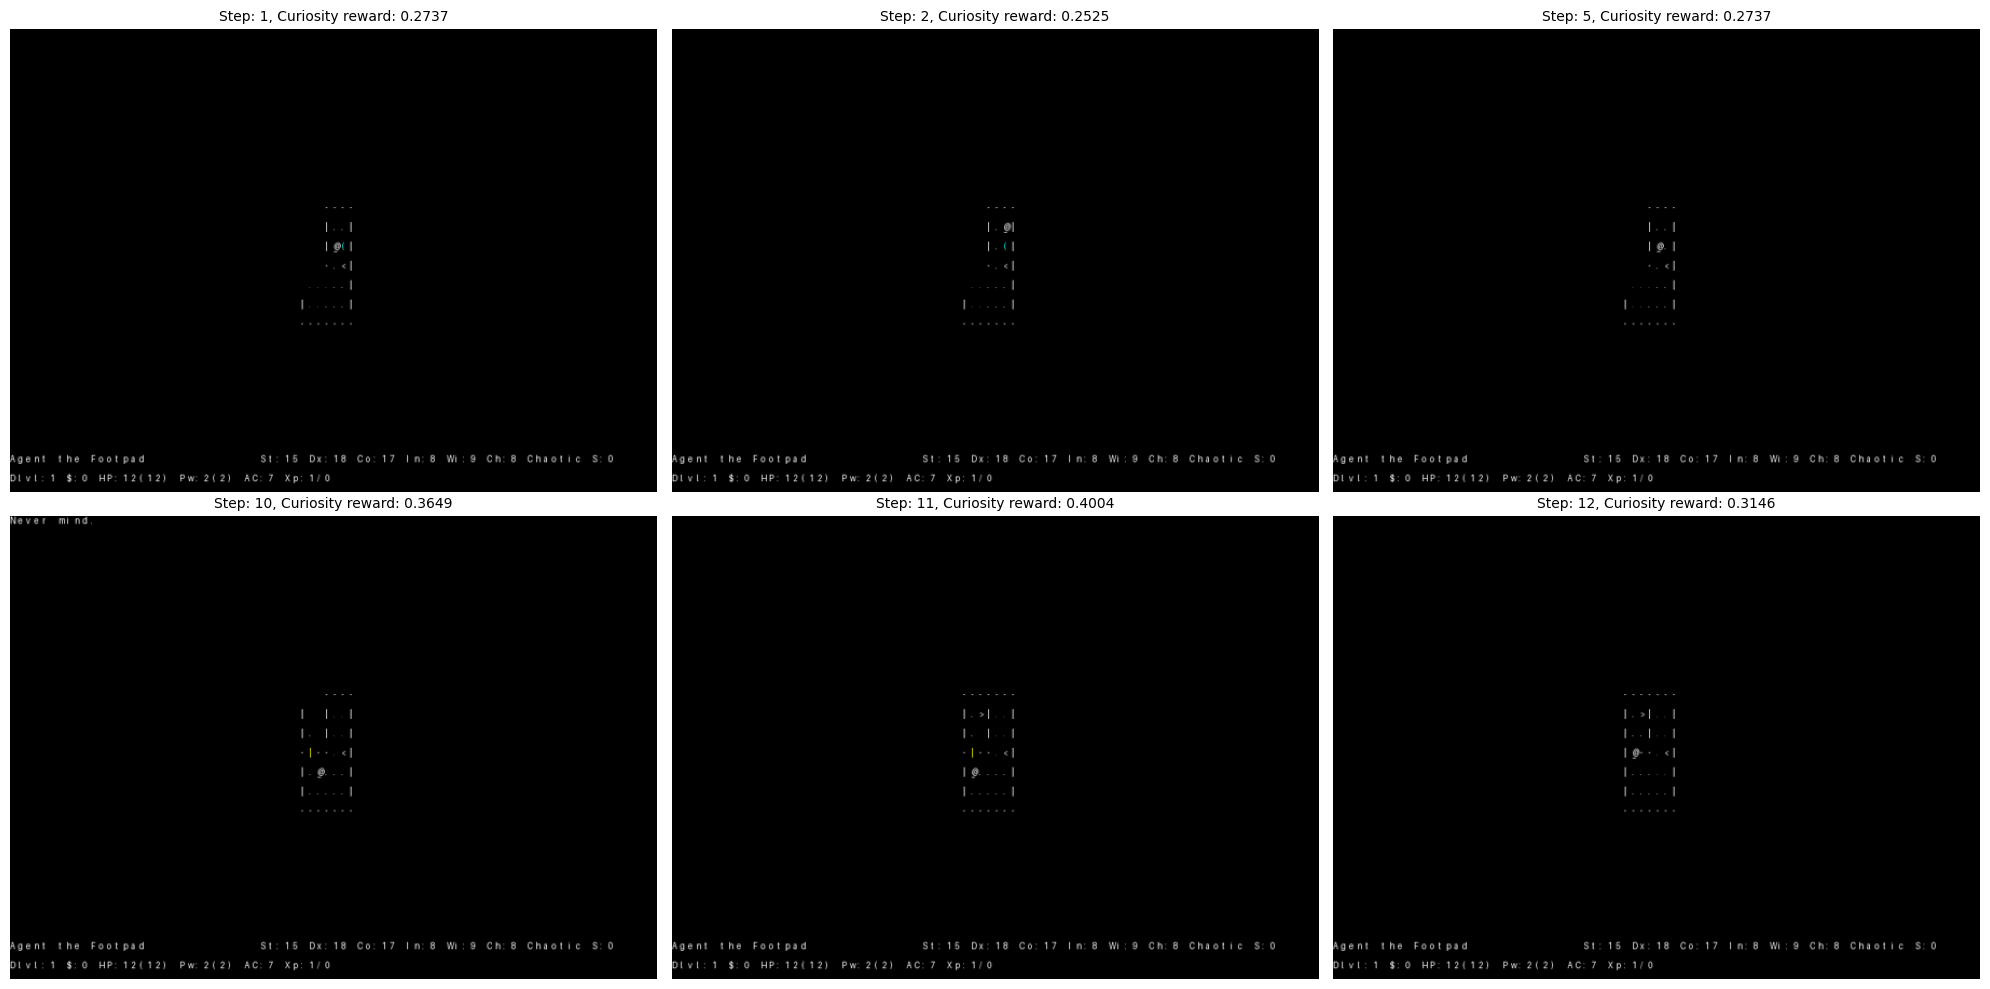

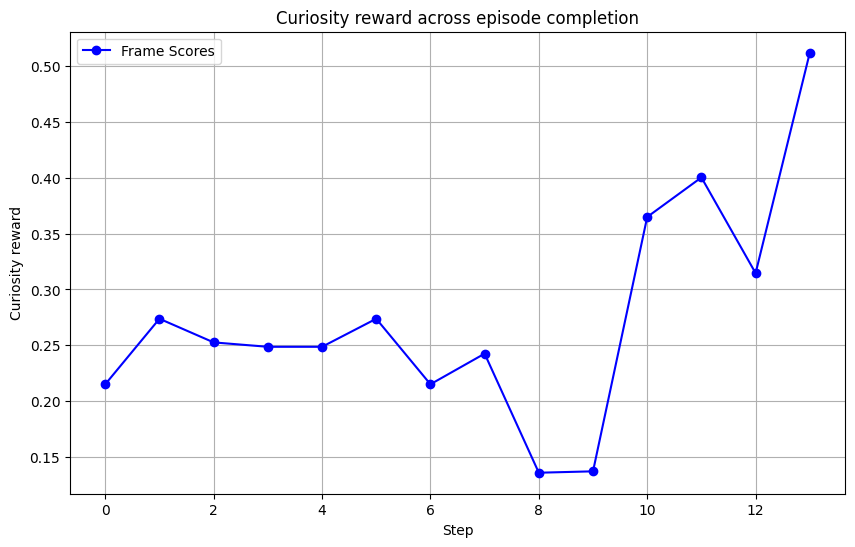

In [22]:
import heapq

unique_scores = list(set(frames_scores))
top_scores = heapq.nlargest(6, unique_scores)
intresting_frames_ixs = set()
for score in top_scores:
    indices_with_score = [ix for ix, val in enumerate(frames_scores) if val == score]
    intresting_frames_ixs.update(indices_with_score)
intresting_frames_ixs = list(intresting_frames_ixs)
intresting_frames_ixs.sort()

selected_frames = []
selected_scores = []
for ix in intresting_frames_ixs:
    selected_frames.append(frames[ix])
    selected_scores.append(frames_scores[ix])

images = selected_frames

descriptions = [
    f"Step: {fix}, Curiosity reward: {round(sc, 4)}" for (fix, sc) in zip(intresting_frames_ixs, selected_scores)
]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()
for ax, img, desc in zip(axes, images, descriptions):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(desc, fontsize=10)

plt.tight_layout()
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(list(range(len(frames_scores))), frames_scores, marker='o', linestyle='-', color='b', label='Frame Scores')
plt.title('Curiosity reward across episode completion')
plt.xlabel('Step')
plt.ylabel('Curiosity reward')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
Video("trajectory.mp4", embed=True)

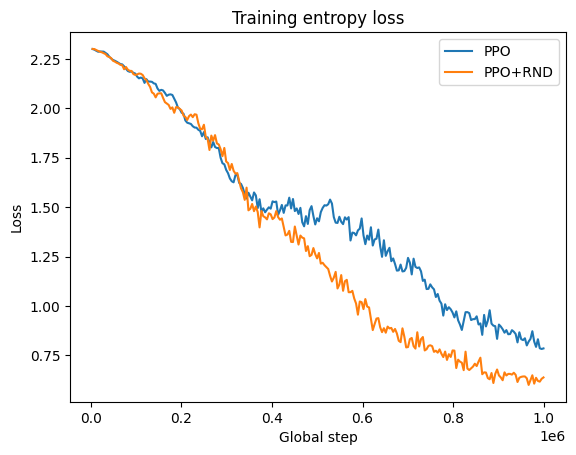

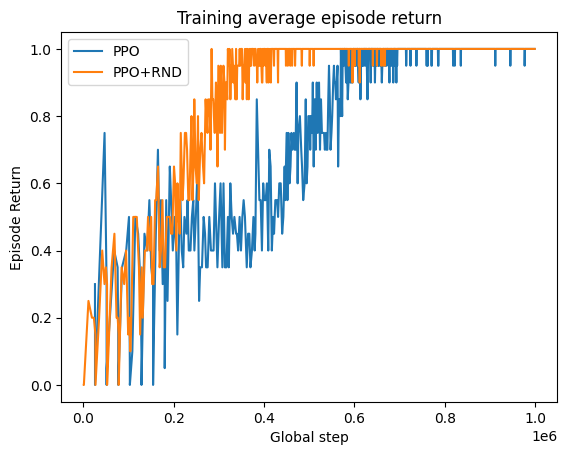

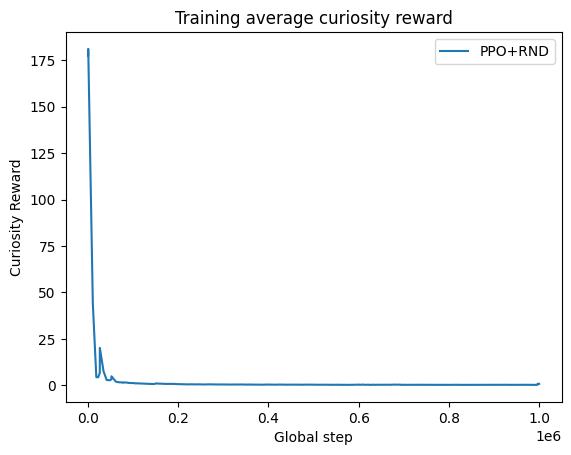

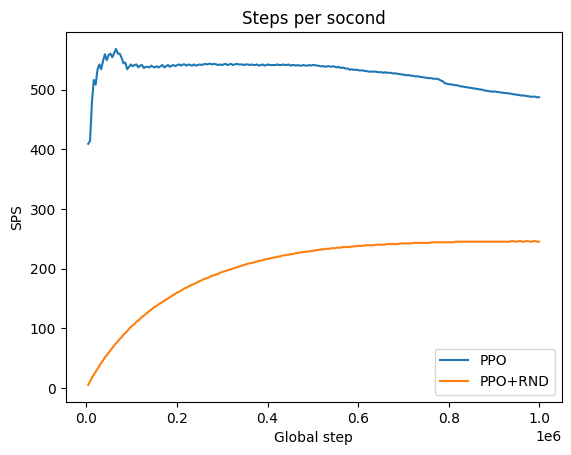

In [24]:
tlol.save_static_plots_in_notebook()
# Below charts that will be saved into notebook for solution evaluation
# IMPORTANT TIP - when training, there is a small chance that ppo will outperform ppo+rnd